# Tutorial: POD-DL-ROM

In [1]:
import sys
import os

os.environ["KERAS_BACKEND"] = "jax"
os.environ["XLA_FLAGS"] = \
    '--xla_gpu_deterministic_ops=true --xla_gpu_autotune_level=0'

import keras
import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(0, '..')
from src.dataset import Dataset
from src.utils import *
from src import Trainer
import src.nns as nns

keras.backend.clear_session()
keras.utils.set_random_seed(1)
np.random.seed(0)

### Data generation
For the sake of simplicity, we consider the following parametrized PDE depending on $\mu \in [2,3]$,

\begin{equation}
\left\{
\begin{aligned}
- \Delta u &= \mu^2 sin(\mu x), & x \in (0,2\pi) \\
u &= \sin(\mu x), &x \in \{0,2\pi\},
\end{aligned}
\right.
\end{equation}

whose exact solution is available analytically, that is, $u(x,\mu) = \sin(\mu x)$. Thus, we generate a set of snapshots varying $\mu$ and choosing $x$ on an equi-spaced grid, thus obtaining the snapshots map $ \{\mathbf{u}_h(\mu)\}_{j=1}^{N_s} \in \mathbb{R}^{N_s \times N_h}$.

In [2]:
# Set problem data and configuration 
p = 1
N_h = 1205
N_s = 400
latent_dim = 3
n_channels = 1
pod_dim = 5
n_train = int(0.8 * N_s)
n_test = int(0.1 * N_s)

# Generate data
X = np.linspace(0, 2*np.pi, N_h)
MU = 2 + np.random.rand(N_s,p)
U = np.sin(np.einsum('ic,j->ijc', MU, X))

### Preliminary dimensionality reduction through POD
POD-DL-ROMs entail a preliminary dimensionality reduction step that allows the user to cast the learning problem at a reduced level, thus improving the both the convergence and the computational performance of the training. 

Indeed, we consider the low-rank based architecture $\mu \mapsto \mathbf{V} \hat{\mathbf{q}}(\mu)$,
where $\mathbf{V} \in \mathbb{R}^{N_h \times pod\_dim}$ is the POD matrix and $\mu \mapsto \hat{\mathbf{q}}(\mu) \in \mathbb{R}^{pod\_dim}$ is a suitable neural network that approximates the POD coefficients. 

Thus, thanks to the (semi-)orthonormality of the POD matrix, we cast the approximation problem at a POD level $\mathbf{V}^T \mathbf{V} \hat{\mathbf{q}} \approx \mathbf{V}^T \mathbf{u}_h \implies \hat{\mathbf{q}} \approx \mathbf{V}^T \mathbf{u}_h = \mathbf{q}$.


In [3]:
# Compute POD on data
pod = POD(pod_dim = pod_dim, n_channels = n_channels, rpod = True)
pod.compute(snapshot_matrix = U[:n_train])
Q = pod.project(u_hf = U)

# Collect data pairs
train_data = {'mu' : MU[:n_train], 'q_true' : Q[:n_train]}
val_data = {'mu' : MU[n_train:-n_test], 'q_true' : Q[n_train:-n_test]}
test_data = {'mu' : MU[-n_test:], 'u_true' : U[-n_test:]}

# Compute POD projection error to assess the efficacy of the preliminary 
# dimensionality reduction
projection_error = pod.compute_projection_error(test_data['u_true'])
print("POD projection error = %1.3e" % projection_error)

# Costruct datasets used for training
train_dataset = Dataset(
    batched_data_ids = list(train_data.keys()),
    sup_data = train_data,
    batch_size_sup = 8
)
val_dataset = Dataset(
    batched_data_ids = list(val_data.keys()),
    sup_data = val_data,
    batch_size_sup = 8
)

2024-10-23 18:23:00.244171: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 11.6 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


POD projection error = 3.769e-03


### Architecture design
Within the next code section, we focus on the definition of the neural network architecture $\mu \mapsto \hat{\mathbf{q}}(\mu) \in \mathbb{R}^{pod\_dim}$. 

Specifically, we design the neural network core by suitably defining a DL-ROM consisting of a reduced network, an encoder and a decoder. 

We remark that $\mu \mapsto \hat{\mathbf{q}}(\mu) = \textnormal{dec} \circ \textnormal{red}(\mu) \approx \mathbf{q}(\mu)$, and the encoder is only used to ensure a suitable latent representation, namely, $\textnormal{enc}(\mathbf{q}(\mu)) \approx \textnormal{red}(\mu)$. Thus, the encoder can be discarded at inference time.

In [4]:
# Define reduce network
reduced_network = nns.DenseNetwork(
    width = 30, 
    depth = 3, 
    output_dim = latent_dim,
    activation = 'elu',
    kernel_initializer = 'he_uniform'
)

# Define encoder
encoder_network = nns.DenseNetwork(
    width = 30, 
    depth = 2, 
    output_dim = latent_dim,
    activation = 'elu',
    kernel_initializer = 'he_uniform'
)
reshape_encoder = keras.layers.Reshape(target_shape = (pod_dim * n_channels, ))
encoder_block = [reshape_encoder, encoder_network]
encoder_network = nns.ops.hstack_nns(
    input_dims = (pod_dim, n_channels),
    blocks = encoder_block
)

# Define decoder
decoder_network = nns.DenseNetwork(
    width = 30, 
    depth = 3, 
    output_dim = pod_dim * n_channels,
    activation = 'elu',
    kernel_initializer = 'he_uniform'
)
reshape_decoder = keras.layers.Reshape(target_shape = (pod_dim, n_channels))
decoder_block = [decoder_network, reshape_decoder]
decoder_network = nns.ops.hstack_nns(
    input_dims = (latent_dim, ),
    blocks = decoder_block
)

# Create a normalizer to normalize in-place the data
normalizer = Normalizer(
    input_train = train_data['mu'], 
    target_train = train_data['q_true']
)

# Create the DL-ROM architecture from the blocks 
# dlrom_training is the architecture used for training 
# dlrom_inference drops the encoder and is used for inference
arch = dict()
arch['reduced_network'] = reduced_network
arch['encoder_network'] = encoder_network
arch['decoder_network'] = decoder_network
dlrom_training, dlrom_inference = nns.dlroms.create_dlrom(
    input_dims = (p, ),
    outputs_dims = (pod_dim, n_channels),
    architecture = arch,
    normalizer = normalizer
)

### Custom loss definition
The library flexibility allows the user to easily define the custom loss functional, which in the case of POD-DL-ROM reads:

\begin{equation*}
    \mathcal{L}_{sup} = \sum_{j} \bigg\|\textnormal{dec} \circ \textnormal{red}(\mu_j) - \mathbf{q}(\mu_j)\bigg\|^2 + \sum_{j} \bigg\|\textnormal{red}(\mu_j) - \textnormal{enc}(\mu_j)\bigg\|^2.
\end{equation*}


In [5]:
class CustomLoss(losses.LossFunction):

    def __init__(self, dlrom,):
        super(CustomLoss, self).__init__()
        self.dlrom = dlrom
    
    def call(self, data, cache = None):
        # Networks forward passes
        # The attribute "sup" is mandatory and indicates that we use supervised 
        # (labeled) data
        (
            output,
            latent_code,
            reduced_output
        ) = self.dlrom((data['mu_sup'], data['q_true_sup']))

        # Loss computation
        loss_rec = keras.ops.mean(
            keras.ops.sum((output - data['q_true_sup'])**2, axis = 1)
        )
        loss_lat = keras.ops.mean(
            keras.ops.sum((reduced_output - latent_code)**2, axis = 1)
        )
        loss = 0.5 * loss_rec + 0.5 * loss_lat

        # Always return a dictionary consisting of losses, and other computed 
        # QoIs
        return {'loss' : loss}

### Training
Despite the simplicity of the user interface, in order to meet the user needs, we provide the user with a plethora of nice functionalities to set up the training.


100%|██████████| 200/200 [00:38<00:00,  5.26it/s, train_loss=2.89e-01, val_loss=1.13e-01]


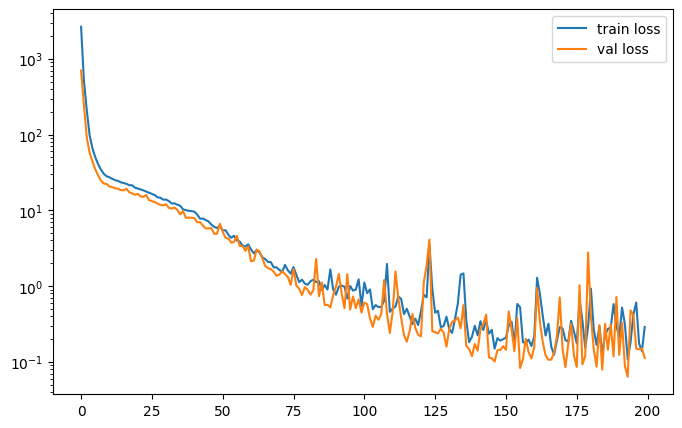

In [6]:
# Set the optimizer and compiling the model
optimizer = keras.optimizers.Adam(learning_rate = 4e-4)
trainer = Trainer(
    loss_model = CustomLoss(
        dlrom = dlrom_training
    )
)
trainer.compile(optimizer = optimizer)

# Set the results directory to store all relevant output files
results_dir = os.path.join('results_tutorial', 'pod-dl-rom')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Set the checkpoint folder to save weights and log files
checkpoint = Checkpoint(save_folder = results_dir)
log_filepath = checkpoint.get_log_filepath(name = 'pod-dl-rom')
weights_filepath = checkpoint.get_weights_filepath(name = 'pod-dl-rom')
log_callback = callbacks.LogCallback(log_filepath)
save_callback = callbacks.SaveCallback(weights_filepath)
load_callback = callbacks.LoadCallback(weights_filepath)

# Train the model
history = trainer.fit(
    train_dataset = train_dataset,
    val_dataset = val_dataset,
    epochs = 200, 
    callbacks = [log_callback, save_callback, load_callback],
    display_options = ('train_loss', 'val_loss')
)

# History contains the relevant quantities computed during the training
# To be selected among the labels provided in display_options
plt.figure(figsize = (8,5))
plt.semilogy(history.container['train_loss'], label = 'train loss')
plt.semilogy(history.container['val_loss'], label = 'val loss')
plt.legend()

### Postprocessing

We finally construct the full architecture by merging the neural network with the POD projection, namely, $\mu \mapsto \mathbf{V} \hat{\mathbf{q}}(\mu) = \mathbf{V} (\textnormal{dec} \circ \textnormal{red})(\mu) \approx \mathbf{u}_h(\mu)$.

Finally, full compatibility with external libraries allows us to compute the accuracy of the chosen method and visualize the POD-DL-ROM prediction.

Mean relative error = 1.534e-02


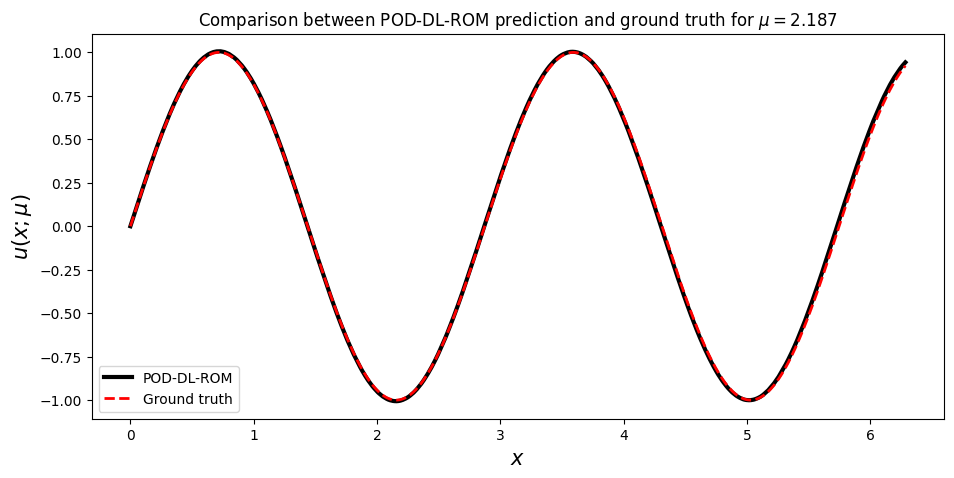

In [7]:
# Instantiate the network to be used for the inference phase as a matrix-vector product
# between the POD matrix and the coefficients inferred by the dlrom
poddlrom_inference = nns.LowRankDecNetwork(
    branch = dlrom_inference,
    trunk = pod
)

# Compute the relative error
mu_test = test_data['mu']
u_true = test_data['u_true']
u_pred = poddlrom_inference.predict(mu = mu_test).block_until_ready()
mean_err = metrics.mean_rel_err_metric(u_true, u_pred)
print('Mean relative error = %1.3e' % mean_err)

# Visualize the solution for one instance of the physical parameter
idx_plot = 0
plt.figure(figsize = (11,5))
plt.plot(X, u_pred[0], 'k', linewidth = 3, label = 'POD-DL-ROM')
plt.plot(X, u_true[0], 'r--', linewidth = 2, label = 'Ground truth')
plt.xlabel('$x$', fontsize = 15)
plt.ylabel('$u(x;\mu)$', fontsize = 15)
plt.title('Comparison between POD-DL-ROM prediction and ground truth for $\mu = $%1.3f' % mu_test[idx_plot][0])
plt.legend()